In [1]:
import Main
import Parser
from Analyser2 import *

In [2]:
modelName = 'Composite'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [5]:
t1 = Main.generate_and_analyse(modelName, {})
t1

{'parentAngle_mean': 29.765372103282797,
 'parentAngle_variance': 2.9769824036553096,
 'length_mean': 1.4146434402113341,
 'length_variance': 1.4012143800188874,
 'verticalOrientation_mean': 20.314620029537686,
 'verticalOrientation_variance': 12.84508118244077,
 'horizontalOrientation_mean': 55.98862932160713,
 'horizontalOrientation_variance': 31.436859827655876,
 'q1_xyz': (1.0, 17.278542494923805, 1.0),
 'q2_xyz': (6.450216935758681, 18.28352985903149, 15.76952200617904),
 'q3_xyz': (6.117304326402441, 22.78779466738721, 16.145278936524697),
 'xyz': (6.668594932668501, 67.30956489717411, 16.599918936524695),
 'trunk_length': 16.568542494923804,
 'totalBiomass': 11.148010051009985}

In [6]:
metrics = {  
    'rule_1_0' : (0,1),
    'rule_1_1' : (0,1),
    'rule_1_2' : (0,1),
    'rule_1_3' : (0,1),
    'general_depth':(2,16),
          }

In [7]:
prior = Distribution(rule_1_0     =RV("uniform", 0, 1),
                     rule_1_1     =RV("uniform", 0, 1),
                     rule_1_2     =RV("uniform", 0, 1),
                     rule_1_3     =RV("uniform", 0, 1),
                     general_depth=RV("uniform", 2, 16)
                    )

In [8]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [9]:
def gen_av_target(targetName, n):
    target = Main.generate_and_analyse(targetName, {})
    for i in range(n):
        print(i)
        new_metrics = Main.generate_and_analyse(targetName, {})
        for (k,v) in new_metrics.items():
            if k[-3:] == 'xyz':
                x,y,z = target[k]
                x += new_metrics[k][0]
                y += new_metrics[k][1]
                z += new_metrics[k][2]
                target[k] = (x,y,z)
            else:
                target[k] += new_metrics[k]

    for (k,v) in target.items():
        if k[-3:] == 'xyz':
            x,y,z = target[k]
            target[k] = (x/n, y/n, z/n)
        else:
            target[k] /= n
            
    return target

In [10]:
target = gen_av_target('SymTree',20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [11]:
target

{'parentAngle_mean': 31.5,
 'parentAngle_variance': 3.15,
 'length_mean': 9.717323165850349,
 'length_variance': 2.321780833113075,
 'verticalOrientation_mean': 51.01271608619291,
 'verticalOrientation_variance': 25.929841375397178,
 'horizontalOrientation_mean': 200.60526315789485,
 'horizontalOrientation_variance': 108.03782424255105,
 'q1_xyz': (4.2, 24.359999999999992, 4.2),
 'q2_xyz': (67.99438170748519, 8.209600000000005, 58.92861690462539),
 'q3_xyz': (71.63168840337988, 21.856184422207406, 65.06391166784991),
 'xyz': (71.63168840337988, 68.95910606170769, 65.06391166784991),
 'trunk_length': 21.0,
 'totalBiomass': 668.018714051312}

In [12]:
mp = 13
me = 0.5

In [13]:
abc = ABCSMC(model, prior, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=106, start_time=2019-04-18 17:17:15.912918, end_time=None)>
INFO:Epsilon:initial epsilon is 70.17365254604792
INFO:ABC:t:0 eps:70.17365254604792
INFO:ABC:t:1 eps:43.779368451601194
INFO:ABC:t:2 eps:36.60239974520942
INFO:ABC:t:3 eps:33.35433699335538
INFO:ABC:t:4 eps:30.701075151286528
INFO:ABC:t:5 eps:28.544212945450635
INFO:ABC:t:6 eps:25.939178422814358
INFO:ABC:t:7 eps:24.867351992292956
INFO:ABC:t:8 eps:24.130833514415425
INFO:ABC:t:9 eps:23.449892852968624
INFO:ABC:t:10 eps:22.902085581545965
INFO:ABC:t:11 eps:22.343214732371194
INFO:ABC:t:12 eps:21.83792169737199
INFO:History:Done <ABCSMC(id=106, start_time=2019-04-18 17:17:15.912918, end_time=2019-04-18 18:07:10.971640)>


In [14]:
from pyabc.visualization import plot_kde_1d

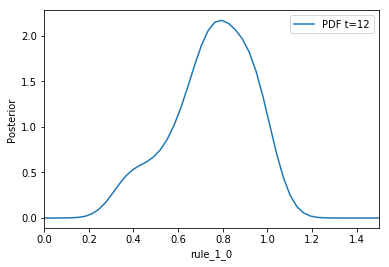

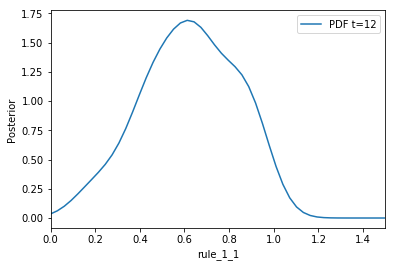

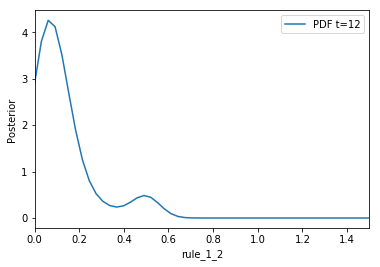

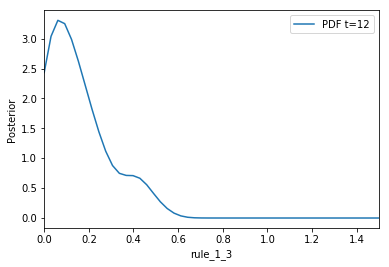

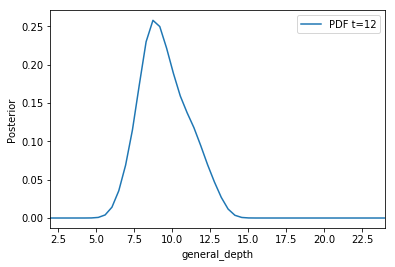

In [15]:
# Visualise results
for k,v in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=1.5*v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();
    fig.savefig('../../../../Report/images/general/'+k+'_kde')